# **Pairs Trading with Cointegration Analysis**

This project implements a market-neutral statistical arbitrage strategy known as pairs trading, focused on identifying and exploiting cointegration relationships between stock pairs. The approach leverages the concept of mean reversion in spread dynamics to construct a long-short strategy that is robust to broader market movements.

We focus on the historical relationship between Coca-Cola (KO) and PepsiCo (PEP), two highly correlated consumer staples. The project walks through:
*   Testing for cointegration to verify a stable long-term relationship.
*   Constructing a mean-reverting spread using linear regression (hedge ratio).
*   Computing the z-score of the spread to define entry and exit signals.
*   Backtesting the strategy with historical data to assess performance.
*   Visualizing the strategy behavior and cumulative returns.

This notebook includes all stages of the pipeline: data acquisition, statistical testing, strategy design, and performance evaluation. The final implementation can be generalized to test multiple stock pairs and fine-tune thresholds for optimal profitability.

Key tools used: yfinance, pandas, numpy, statsmodels, matplotlib, and custom backtesting utilities.

## Part 1 - Stock Pair Selection

In [1]:
!pip install --upgrade yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# The two stocks we'll be analyzing for cointegration purposes are Coca-Cola (KO)
# and PepsiCo (PEP).
tickers = ["KO", "PEP"]
data = yf.download(tickers, start="2018-01-01", end="2023-12-31", auto_adjust=False)

[*********************100%***********************]  2 of 2 completed


"Close" represents the raw closing price of the stock on that trading day, reflecting the last price at which the stock was traded during regular market hours.

"Adj Close" accounts for corporate actions such as stock splits, dividends, and other distributions.

In [4]:
# Cleaning data to get rid of rows with missing values
data.dropna(inplace=True)
data.head()

Price       Adj Close                 Close                   High  \
Ticker             KO        PEP         KO         PEP         KO   
Date                                                                 
2018-01-02  36.272221  95.272133  45.540001  118.059998  45.939999   
2018-01-03  36.192562  95.021965  45.439999  117.750000  45.689999   
2018-01-04  36.702324  95.490013  46.080002  118.330002  46.220001   
2018-01-05  36.694351  95.764374  46.070000  118.669998  46.200001   
2018-01-08  36.638603  95.215637  46.000000  117.989998  46.099998   

Price                         Low                   Open              \
Ticker             PEP         KO         PEP         KO         PEP   
Date                                                                   
2018-01-02  120.180000  45.509998  117.930000  45.910000  119.930000   
2018-01-03  118.470001  45.340000  117.639999  45.490002  117.910004   
2018-01-04  119.110001  45.450001  117.599998  45.560001  117.800003   
2018-01-05  119.089996  45.790001  118.250000  46.020000  118.410004   
2018-01-08  118.739998  45.880001  117.669998  45.950001  118.209999   

Price         Volume           
Ticker            KO      PEP  
Date                           
2018-01-02  10872200  4165800  
2018-01-03  12635600  4224000  
2018-01-04  12709400  3147000  
2018-01-05  13113100  2714200  
2018-01-08   7068600  5730400

The reason I selected Coca-Cola and Pepsico for the following cointegration analysis is because both companies are consumer staples within the beverages sector, which imply that they have the potential for economic linkage and, therefore, a higher chance for stationarity of their spread.

In [5]:
print(data.keys())

MultiIndex([('Adj Close',  'KO'),
            ('Adj Close', 'PEP'),
            (    'Close',  'KO'),
            (    'Close', 'PEP'),
            (     'High',  'KO'),
            (     'High', 'PEP'),
            (      'Low',  'KO'),
            (      'Low', 'PEP'),
            (     'Open',  'KO'),
            (     'Open', 'PEP'),
            (   'Volume',  'KO'),
            (   'Volume', 'PEP')],
           names=['Price', 'Ticker'])


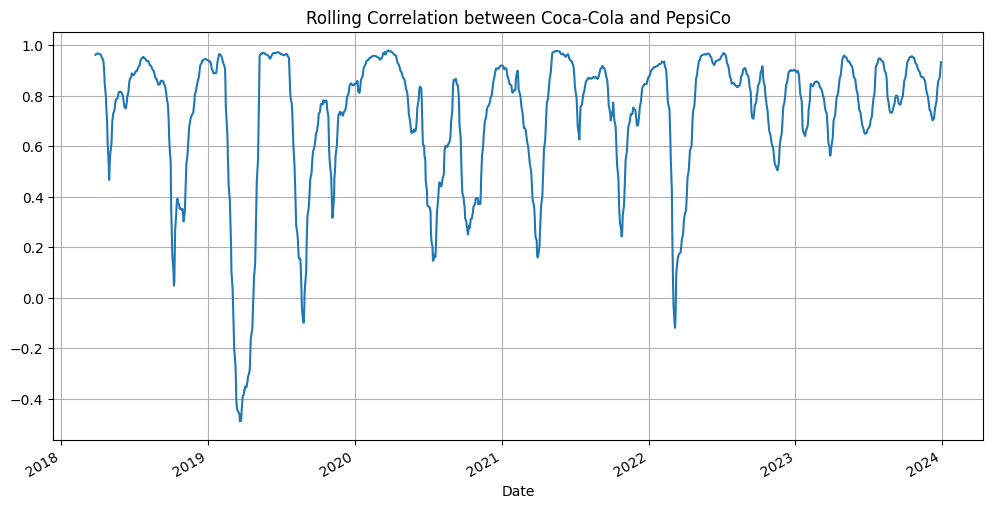

In [6]:
# Before cointegration testing, determine whether the correlation between the stocks
# over the last 60 days is stable
rolling_corr = data[('Adj Close', 'KO')].rolling(window=60).corr(data[('Adj Close', 'PEP')])
rolling_corr.plot(figsize=(12, 6), title='Rolling Correlation between Coca-Cola and PepsiCo')
plt.grid(True)
plt.show()

A rolling correlation is the correlation coefficient computed over a sliding window (in this case, 60 days.)

This informs us about how the stocks have moved together over time, rather than just looking at full-period correlation.

Because of the high degree of correlation throughout the course of the 5-year window, we can determine that the two stocks generally move very similarly - **an advantage for pair trading** (because stable historical correlation can help build confidence in a spread relationship.)

The sharp dips in correlation, however, indicate that naive cointegration strategies may not be able to handle shocks in volatility and may require event filtering or regime detection.

In [7]:
print("Mean corr:", rolling_corr.mean())
print("Min corr:", rolling_corr.min())
print("Std dev of rolling corr:", rolling_corr.std())

Mean corr: 0.7204193984558901
Min corr: -0.4902566206183801
Std dev of rolling corr: 0.278053600387218


Before we move on, it's important to build the intuition behind what exactly a pairs trading strategy is. Specifically, a *pairs trading strategy* is a type of "mean-reversion strategy", meaning that it bets that the price relationship, or spread, of two *historically linked assets* will return to its typical behavior after diverging. We only care about the relative movements of the stocks with respect to one another.

The sign of the z-score tells us whether the spread has widened or narrowed compared to its average. That then tells us which stock is relatively stronger or weaker - and how to trade accordingly. The table below illustrates a good rule of thumb for what trading strategies to pursue given a computed z-score.

| Z-score    | Interpretation         | Trade                     |
|------------|------------------------|---------------------------|
| z > +1.5   | KO is high vs. PEP     | Short KO, Long PEP        |
| z < -1.5   | KO is low vs. PEP      | Long KO, Short PEP        |
| z ≈ 0      | Spread has reverted     | Close both positions       |

## Part 2 - Cointegration Tests

Now, with the cointegration tests, our aim is to determine whether a computed spread actually makes sense to bet on statistically. Definitively, this means verifying whether the spread between the two stocks, KO and PEP, are indeed mean-reverting (and not just correlated.)

The coint() method, used below, has the null hypothesis that there exists no cointegration between our two selected stocks. If p < 0.05, we are able to reject the null hypothesis and determine that the spread is indeed stationary.

In [8]:
from statsmodels.tsa.stattools import coint

# Compute cointegration test on Adjusted Close price values of both stocks
ko = data[('Adj Close', 'KO')]
pep = data[('Adj Close', 'PEP')]

# KO on PEP
score1, pval1, _ = coint(ko, pep)

# PEP on KO
score2, pval2, _ = coint(pep, ko)

print(f"KO~PEP p-value: {pval1:.4f} | PEP~KO p-value: {pval2:.4f}")

KO~PEP p-value: 0.0416 | PEP~KO p-value: 0.0656


The outputs above indicate that there exists a mean-reverting relationship between the two variables when KO is the dependent variable and PEP is the independent variable (i.e., KO - beta * PEP is the better cointegrating relationship.)

Additionally, we can employ Johansen's test, which is multivariate and doesn't assume that one series depends on the other.

In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

log_data = np.log(data['Adj Close'])
johan_test = coint_johansen(log_data, det_order=0, k_ar_diff=1)

print("Johansen Trace Statistics:")
print(johan_test.lr1)
print("Critical Values (90%, 95%, 99%):")
print(johan_test.cvt)

Johansen Trace Statistics:
[15.13959343  0.99426877]
Critical Values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


While Johansen's test was marginal at 95% (which we can see because 15.13 < 15.49), the Engle-Granger test provided stronger statistical confirmation of cointegration between KO and PEP. We proceed under the assumption of a valid long-term equilibrium relationship.

## Part 3 - Hedge Ratio Estimation

The hedge ratio defines the relative weighting between the two assets in our synthetic spread. We estimate it by regressing KO on PEP, since we found KO~PEP gives statistically significant cointegration.

This means that our spread should be constructed as Spread_t = KO_t - beta * PEP_t.

To begin, we first run OLS regression to estimate beta.

In [10]:
from statsmodels.tsa.stattools import adfuller

X = sm.add_constant(pep)
model = sm.OLS(ko, X).fit()
hedge_ratio = model.params[1]
print("Hedge Ratio:", hedge_ratio)

spread = ko - hedge_ratio * pep

Hedge Ratio: 0.2707759038454416


<ipython-input-10-354c7706f55e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


As a quick sanity check, we can manually construct the spread using the hedge ratio and then compute whether the spread is stationary.

In [11]:
adf_result = adfuller(spread)
print(f"ADF Stat: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

ADF Stat: -3.4060, p-value: 0.0108


Because the p-value is so low (0.01 < 0.05), we can safely reject the null hypothesis and conclude that the spread is stationary.

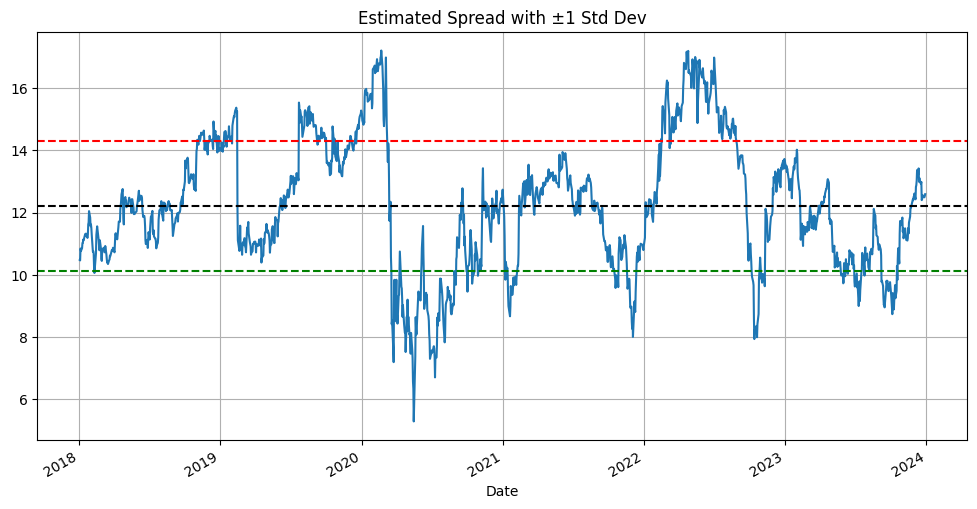

In [12]:
# Visual checks of the residuals/spreads
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black', linestyle='--')
plt.axhline(spread.mean() + spread.std(), color='red', linestyle='--')
plt.axhline(spread.mean() - spread.std(), color='green', linestyle='--')
plt.title("Estimated Spread with ±1 Std Dev")
plt.grid(True)
plt.show()

A rolling hedge ratio is essentially the hedge ratio (beta) re-estimated over a moving window of time, rather than simply being calculated over the entire dataset.

### Deriving the Rolling Hedge Ratio

**Rolling β (No Intercept) = correlation × (std_X / std_Y)**

We want to show that the slope β from a simple linear regression with **no intercept**:

    X = β × Y + ε

can be approximated as:

    β = corr(X, Y) × (std(X) / std(Y))

---

#### Step 1: OLS Estimate Without Intercept

For the model `X = β × Y`, the least-squares solution (minimizing squared error) is:

    β = Σ(X_i * Y_i) / Σ(Y_i^2)

This is the closed-form solution for regression with no intercept.

---

#### Step 2: Express in Terms of Covariance and Variance

Recall:

- Cov(X, Y) = average of (X_i × Y_i)
- Var(Y) = average of (Y_i^2)

So we can rewrite β as:

    β = Cov(X, Y) / Var(Y)

---

#### Step 3: Use the Definition of Correlation

    corr(X, Y) = Cov(X, Y) / (std(X) × std(Y))

Solving for Cov(X, Y):

    Cov(X, Y) = corr(X, Y) × std(X) × std(Y)

---

#### Step 4: Substitute Into β

    β = [corr(X, Y) × std(X) × std(Y)] / [std(Y)^2]
      = corr(X, Y) × (std(X) / std(Y))

---

### Final Result

    β = correlation × (std_X / std_Y)

This is the basis for fast, rolling hedge ratio estimation without running full regressions. It assumes no intercept and is useful for adaptive stat arb strategies.

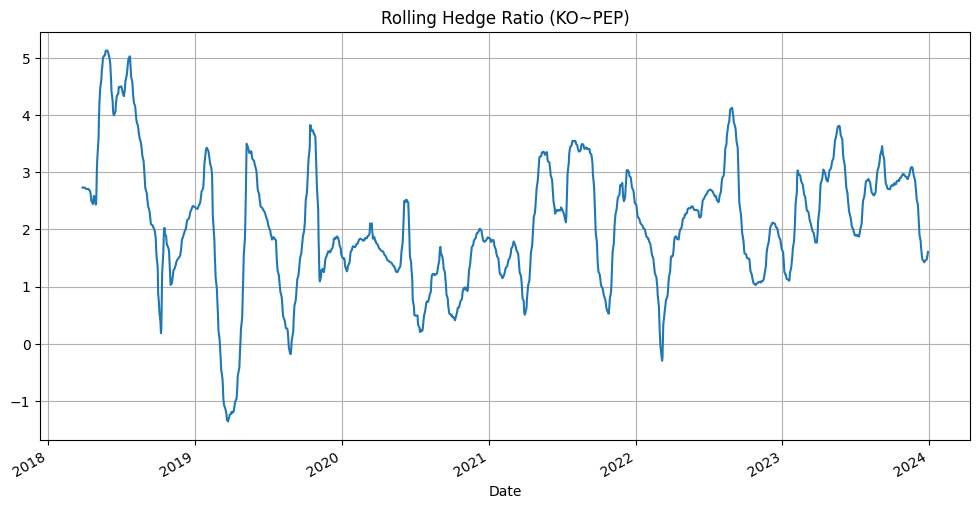

In [13]:
# Using above derivation, we can compute a rolling hedge ratio across the entire
# time frame of the ticker data (we'll use a 60-day window here)
window = 60
rolling_hedge_ratio = ko.rolling(window=window).corr(pep) * (pep.rolling(window=window).std() / ko.rolling(window=window).std())
rolling_hedge_ratio.plot(figsize=(12, 6), title='Rolling Hedge Ratio (KO~PEP)')
plt.grid(True)
plt.show()

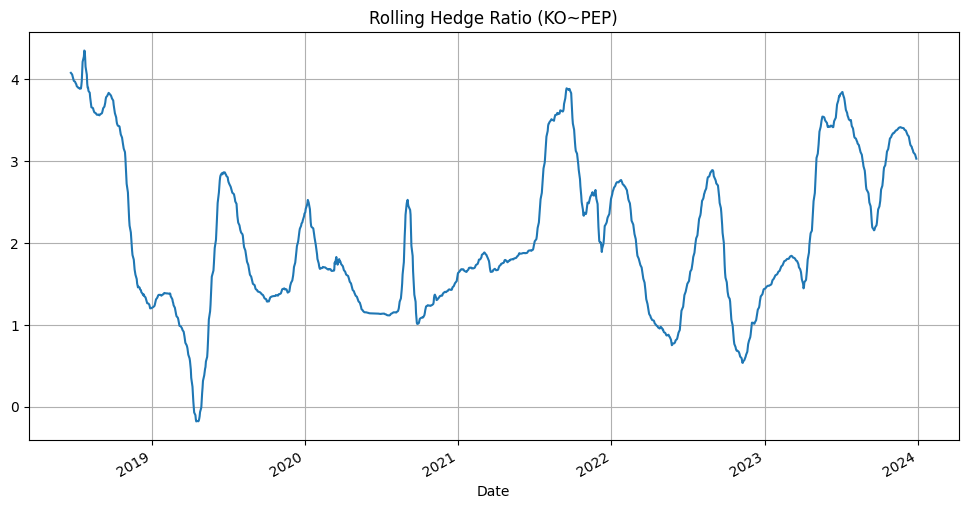

In [14]:
# Using a different time window (120 days)
window_2 = 120
rolling_hedge_ratio_2 = ko.rolling(window=window_2).corr(pep) * (pep.rolling(window=window_2).std() / ko.rolling(window=window_2).std())
rolling_hedge_ratio_2.plot(figsize=(12, 6), title='Rolling Hedge Ratio (KO~PEP)')
plt.grid(True)
plt.show()

We can quantitatively evaluate the different rolling hedge ratio choices by computing the spread of both on the KO and PEP adjusted close prices and running the ADF test on the spreads to determine which choice has the lower p-value/more negative test stat.

In [17]:
spread_60 = ko - rolling_hedge_ratio * pep
spread_120 = ko - rolling_hedge_ratio_2 * pep

spread_60.dropna(inplace=True)
spread_120.dropna(inplace=True)

adf_result_60 = adfuller(spread_60)
adf_result_120 = adfuller(spread_120)

print(adf_result_60)
print(adf_result_120)

(np.float64(-5.208914288009159), np.float64(8.431031998213916e-06), 2, 1447, {'1%': np.float64(-3.4348772553489617), '5%': np.float64(-2.8635394783531085), '10%': np.float64(-2.5678345067434516)}, np.float64(9646.477125980298))
(np.float64(-2.9990867282673803), np.float64(0.03497977643067111), 10, 1379, {'1%': np.float64(-3.4351009168670035), '5%': np.float64(-2.863638180853028), '10%': np.float64(-2.5678870681532424)}, np.float64(7851.496839094056))


Given that the p-value for the 60-day spread is orders of magnitude smaller than that of the 120-day spread, as well as how much more negative the former's test stat is compared to the latter's, we can determine that the 60-day rolling beta produces a spread that is **significantly more stationary**.

## Part 4 - Strategy Logic

Now, we can derive actual strategies using the previously computed 60-day spread to inform our signal logic and when to enter or exit specific trades.

In [34]:
# Define parameters and compute z-scores
entry_threshold = 1.5
exit_threshold = 0.05
lookback = 60

spread_60_mean = spread_60.rolling(window=lookback).mean()
spread_60_std = spread_60.rolling(window=lookback).std()
z_scores = (spread_60 - spread_60_mean) / spread_60_std

# Drop missing values
spread_60_mean.dropna(inplace=True)
spread_60_std.dropna(inplace=True)
z_scores.dropna(inplace=True)

In [35]:
print(spread_60_mean.head())
print(spread_60_std.head())
print(z_scores.head())

Date
2018-06-21   -275.902118
2018-06-22   -278.292447
2018-06-25   -280.771184
2018-06-26   -283.423248
2018-06-27   -286.073380
dtype: float64
Date
2018-06-21    79.738761
2018-06-22    79.808123
2018-06-25    79.874685
2018-06-26    79.905718
2018-06-27    79.913066
dtype: float64
Date
2018-06-21   -0.865166
2018-06-22   -0.912075
2018-06-25   -0.941863
2018-06-26   -0.990607
2018-06-27   -0.981026
dtype: float64


The intuition below defines our signal logic more concretely:
*   If z > +entry_threshold, KO is too expensive vs. PEP --> short KO, long PEP
*   If z < -entry_threshold, KO is too cheap vs. PEP --> long KO, short PEP
*   If |z| < exit_threshold, the spread has normalized --> exit the position

Now, we compute the entry/exit signals and store the results in a DataFrame.

In [36]:
positions = pd.DataFrame(index=spread_60_mean.index)

positions["Long"] = (z_scores < -entry_threshold).astype(int)
positions["Short"] = (z_scores > entry_threshold).astype(int)
positions["Exit"] = (abs(z_scores) < exit_threshold).astype(int)

# Keep the z-scores in the DataFrame as well for debugging
positions["Z-Score"] = z_scores

positions.head(100)

,Long,Short,Exit,Z-Score
Date,,,,
2018-06-21,0,0,0,-0.865166
2018-06-22,0,0,0,-0.912075
2018-06-25,0,0,0,-0.941863
2018-06-26,0,0,0,-0.990607
2018-06-27,0,0,0,-0.981026
...,...,...,...,...
2018-11-05,0,0,0,1.053803
2018-11-06,0,0,0,0.967679
2018-11-07,0,0,0,0.892313


Based on the above entry/exit signals, we define some logic below that helps us illustrate the current position we're in (either long or short wrt KO) and also when to exit said position.

In [39]:
positions['curr_position'] = 0
in_position = 0  # 0 = no trade, 1 = long, -1 = short (wrt KO)

for i in range(1, len(positions)):
    long_signal = positions.iloc[i]['Long']
    short_signal = positions.iloc[i]['Short']
    exit_signal = positions.iloc[i]['Exit']

    if in_position == 0:
        if long_signal == 1:
            in_position = 1
        elif short_signal == 1:
            in_position = -1
    elif in_position != 0:
        if exit_signal == 1:
            in_position = 0

    positions.iat[i, positions.columns.get_loc('curr_position')] = in_position

positions.head(200)

,Long,Short,Exit,Z-Score,curr_position
Date,,,,,
2018-06-21,0,0,0,-0.865166,0
2018-06-22,0,0,0,-0.912075,0
2018-06-25,0,0,0,-0.941863,0
2018-06-26,0,0,0,-0.990607,0
2018-06-27,0,0,0,-0.981026,0
...,...,...,...,...,...
2019-04-02,0,0,0,1.361729,1
2019-04-03,0,0,0,1.317197,1
2019-04-04,0,0,0,1.258332,1


## Part 5 - Backtesting Engine

Now that we've successfully defined our core strategy logic using z-score entry/exit thresholds and defining the current position we hold over the entire ticker window, we can begin our backtesting section, which will consist of:
*   Tracking daily returns using `curr_position`
*   Apply the hedge ratio to compute PnL of both legs
*   Build a cumulative PnL curve
*   Evaluate CAGR, Sharpe ratio, max drawdown, and win rate/avg hold time



A robust backtest needs the following:
*   Daily PnL calculation (e.g., computing profit and loss from long and short legs)
*   Portfolio value tracking (e.g., tracking how capital evolves over time)
*   Performance metrics (specifically, the ones illustrated above)



In [52]:
# Re-writing variables for convenience
lookback = 60
ko = data[('Adj Close', 'KO')]
pep = data[('Adj Close', 'PEP')]

rolling_hedge_ratio = ko.rolling(window=lookback).corr(pep) * (
    pep.rolling(window=lookback).std() / ko.rolling(window=lookback).std()
)

# Compute rolling spread (as used in z-score logic)
spread_60 = ko - rolling_hedge_ratio * pep

# Compute daily returns
data['KO_return'] = ko.pct_change()
data['PEP_return'] = pep.pct_change()

# Merge all necessary components into one aligned DataFrame
merged = pd.DataFrame(index=data.index)
merged['KO_return'] = data['KO_return']
merged['PEP_return'] = data['PEP_return']
merged['curr_position'] = positions['curr_position']
merged['hedge_ratio'] = rolling_hedge_ratio

# Dropping missing values in-place
merged.dropna(inplace=True)

# Compute leg-wise and total strategy returns
merged['KO_leg'] = merged['curr_position'] * merged['KO_return']
merged['PEP_leg'] = -merged['curr_position'] * merged['hedge_ratio'] * merged['PEP_return']
merged['strategy_ret'] = merged['KO_leg'] + merged['PEP_leg']

# Compute cumulative returns
merged['cumulative_returns'] = (1 + merged['strategy_ret']).cumprod()

merged.head(200)

,KO_return,PEP_return,curr_position,hedge_ratio,KO_leg,PEP_leg,strategy_ret,cumulative_returns
Date,,,,,,,,
2018-06-21,-0.003930,0.013515,0.0,4.317038,-0.000000,-0.000000,-0.000000,1.000000
2018-06-22,0.003713,0.010537,0.0,4.343149,0.000000,-0.000000,0.000000,1.000000
2018-06-25,0.007630,0.005721,0.0,4.376445,0.000000,-0.000000,0.000000,1.000000
2018-06-26,-0.005737,-0.008624,0.0,4.486416,-0.000000,0.000000,0.000000,1.000000
2018-06-27,-0.006000,0.002036,0.0,4.496223,-0.000000,-0.000000,-0.000000,1.000000
...,...,...,...,...,...,...,...,...
2019-04-02,-0.003210,-0.002623,1.0,-1.201758,-0.003210,-0.003152,-0.006363,1.096006
2019-04-03,-0.008374,-0.000986,1.0,-1.213272,-0.008374,-0.001196,-0.009571,1.085516
2019-04-04,0.006496,-0.000740,1.0,-1.189053,0.006496,-0.000880,0.005616,1.091613


#### Interpreting Position Direction in a Pairs Trading Strategy

In our strategy, we define the current trading position using a curr_position variable:

+1 → Long KO, Short PEP

-1 → Short KO, Long PEP

0 → No position / Exited trade

This value is always defined with respect to KO, our reference asset.

Intuition:
When the z-score is significantly negative (e.g. < -1.5), it means KO is undervalued vs. PEP.
→ We go long KO (betting it will rise) and short PEP (betting it will fall).
→ curr_position = +1

When the z-score is significantly positive (e.g. > +1.5), it means KO is overvalued vs. PEP.
→ We short KO (betting it will fall) and long PEP (betting it will rise).
→ curr_position = -1

When the z-score reverts near zero (i.e., enters the exit threshold of [-0.05,0.05]), the spread has normalized.
→ We exit the trade, closing both positions.
→ curr_position = 0

Key Insight:
The z-score is just a signal — it helps identify entry and exit points.
**But the position value (+1 or -1) is our actual action, relative to KO.**

This framing ensures consistency, generalizes to other asset pairs, and aligns with real-world statistical arbitrage logic.

In these next code cells, we introduce an updated backtesting engine that incorporates max holding periods for specific trades, as well as take-profit/stop-loss bands to signal an exit from a given position. Moreover, we introduce a mandatory cooldown period of 5 days to ensure that after a trade is exited, our strategy does not immediately re-start trading once more, even if the z-score of a spread is beyond a provided entry threshold.

In [48]:
lookback = 60
ko = data[('Adj Close', 'KO')]
pep = data[('Adj Close', 'PEP')]

rolling_hedge_ratio = ko.rolling(window=lookback).corr(pep) * (
    pep.rolling(window=lookback).std() / ko.rolling(window=lookback).std()
)

spread_60 = ko - rolling_hedge_ratio * pep
data['KO_return'] = ko.pct_change()
data['PEP_return'] = pep.pct_change()

merged_v2 = pd.DataFrame(index=data.index)
merged_v2['KO_return'] = data['KO_return']
merged_v2['PEP_return'] = data['PEP_return']
merged_v2['curr_position'] = positions['curr_position']
merged_v2['hedge_ratio'] = rolling_hedge_ratio
merged_v2.dropna(inplace=True)

In [66]:
max_hold_days = 20
take_profit = 0.10
stop_loss = -0.05

merged_v2['KO_leg'] = 0.0
merged_v2['PEP_leg'] = 0.0
merged_v2['strategy_ret'] = 0.0
merged_v2['cumulative_returns'] = 1.0
merged_v2['executed_position'] = 0

in_trade = False
entry_index = None
entry_cumret = 1.0
days_held = 0
position = 0

cooldown_days = 5
cooldown_counter = 0

for i in range(len(merged_v2)):
    row = merged_v2.iloc[i]
    date = merged_v2.index[i]
    pos_signal = row['curr_position']

    if not in_trade and pos_signal != 0 and cooldown_counter == 0:
        in_trade = True
        entry_index = i
        entry_cumret = 1.0
        days_held = 0
        position = pos_signal

    if in_trade:
        ko_leg = position * row['KO_return']
        pep_leg = -position * row['hedge_ratio'] * row['PEP_return']
        strat_ret = ko_leg + pep_leg
        entry_cumret *= (1 + strat_ret)
        days_held += 1
    else:
        ko_leg = 0.0
        pep_leg = 0.0
        strat_ret = 0.0

    merged_v2.at[date, 'KO_leg'] = ko_leg
    merged_v2.at[date, 'PEP_leg'] = pep_leg
    merged_v2.at[date, 'strategy_ret'] = strat_ret
    merged_v2.at[date, 'executed_position'] = position if in_trade else 0
    if i > 0:
        merged_v2.at[date, 'cumulative_returns'] = merged_v2.iloc[i - 1]['cumulative_returns'] * (1 + strat_ret)
    else:
        merged_v2.at[date, 'cumulative_returns'] = 1.0

    if in_trade:
        if (
            pos_signal == 0 or
            days_held >= max_hold_days or
            entry_cumret - 1 >= take_profit or
            entry_cumret - 1 <= stop_loss
        ):
            in_trade = False
            entry_index = None
            days_held = 0
            position = 0
            cooldown_counter = cooldown_days + 1

    if cooldown_counter > 0:
        cooldown_counter -= 1

merged_v2.head(500)

,KO_return,PEP_return,curr_position,hedge_ratio,KO_leg,PEP_leg,strategy_ret,cumulative_returns,KO_cumret,PEP_cumret,executed_position
Date,,,,,,,,,,,
2018-06-21,-0.003930,0.013515,0.0,4.317038,0.000000,0.000000,0.000000,1.000000,0.996070,1.013515,0
2018-06-22,0.003713,0.010537,0.0,4.343149,0.000000,0.000000,0.000000,1.000000,0.999768,1.024194,0
2018-06-25,0.007630,0.005721,0.0,4.376445,0.000000,0.000000,0.000000,1.000000,1.007397,1.030054,0
2018-06-26,-0.005737,-0.008624,0.0,4.486416,0.000000,0.000000,0.000000,1.000000,1.001618,1.021170,0
2018-06-27,-0.006000,0.002036,0.0,4.496223,0.000000,0.000000,0.000000,1.000000,0.995608,1.023249,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,-0.007755,0.008724,1.0,2.489102,-0.007755,-0.021715,-0.029470,1.652920,1.188960,1.345829,1
2020-06-11,-0.063348,-0.046895,1.0,2.516975,-0.063348,0.118033,0.054685,1.743310,1.113642,1.282717,1
2020-06-12,0.010414,0.009074,1.0,2.502653,0.010414,-0.022708,-0.012294,1.721877,1.125239,1.294356,1


In the future, we could include additional elements to the backtesting engine to more closely model real-world statistical arbitrage, such as transaction costs and slippage; capital allocation logic; a portfolio of cointegrated pairs of assets; and live simulation of the trading strategy.

## Part 6 - Performance Comparison

To begin, we can start by plotting our cumulative returns alongside the respective cumulative returns for the KO and PEP stocks themselves.

In [55]:
# Create cumulative return columns for KO and PEP
merged_v2['KO_cumret'] = (1 + merged_v2['KO_return']).cumprod()
merged_v2['PEP_cumret'] = (1 + merged_v2['PEP_return']).cumprod()

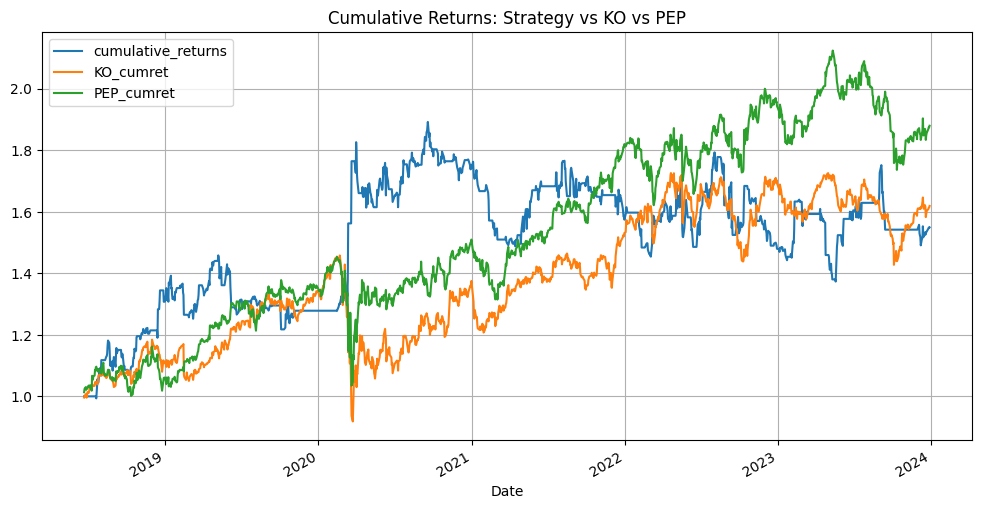

In [57]:
merged_v2[['cumulative_returns', 'KO_cumret', 'PEP_cumret']].plot(figsize=(12, 6), title='Cumulative Returns: Strategy vs KO vs PEP')
plt.grid(True)
plt.show()


In [60]:
# Relevant Performance Metrics - total return, CAGR, annualized volatility,
# Sharpe ratio, max drawdown
strategy_returns = merged_v2['strategy_ret']
cumulative_returns = merged_v2['cumulative_returns']

total_return = cumulative_returns.iloc[-1] - 1

days = (merged_v2.index[-1] - merged_v2.index[0]).days
years = days / 365.25
cagr = (cumulative_returns.iloc[-1])**(1/years) - 1

annualized_vol = strategy_returns.std() * np.sqrt(252)

sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

# Max Drawdown (MDD) measures the worst peak-to-trough drop in your cumulative returns during the entire trading period.
# (In simple terms: How much did your portfolio fall from its highest value before it recovered again?)
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()

In [61]:
print(f"Total Return: {total_return:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Annualized Volatility: {annualized_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

Total Return: 54.89%
CAGR: 8.25%
Annualized Volatility: 22.33%
Sharpe Ratio: 0.47
Max Drawdown: -27.42%


In [67]:
# Statistics about the trades themselves using executed_position
trade_count = 0
win_trades = 0
holding_periods = []

in_trade = False
entry_value = 1.0
entry_date = None
days_held = 0

for i in range(len(merged_v2)):
    row = merged_v2.iloc[i]
    pos = row['executed_position']

    if not in_trade and pos != 0:
        # Start of a new trade
        in_trade = True
        entry_value = row['cumulative_returns']
        entry_date = merged_v2.index[i]
        days_held = 1
    elif in_trade and pos != 0:
        # Still in the same trade
        days_held += 1
    elif in_trade and pos == 0:
        # Trade just exited
        in_trade = False
        exit_value = row['cumulative_returns']
        trade_count += 1
        if exit_value > entry_value:
            win_trades += 1
        holding_periods.append(days_held)

# Compute metrics
win_rate = win_trades / trade_count if trade_count > 0 else np.nan
avg_holding_period = np.mean(holding_periods) if holding_periods else np.nan

In [68]:
print(f"Number of Trades: {trade_count}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Average Holding Period: {avg_holding_period:.2f} days")

Number of Trades: 59
Win Rate: 47.46%
Average Holding Period: 13.90 days


#### Strategy Summary & Key Takeaways

- **Strategy Objective**: This statistical arbitrage strategy is designed to exploit **mean-reverting price behavior** between two historically cointegrated assets — KO and PEP — using z-score thresholds to identify mispricings.

- **Trade Mechanics**:
  - **Long KO / Short PEP** when KO is undervalued (z < -1.5).
  - **Short KO / Long PEP** when KO is overvalued (z > +1.5).
  - **Exit** when spread reverts (z ≈ 0), take-profit (+10%), stop-loss (-5%), or max holding period (20 days) is hit.
  - A **cooldown period** of 5 days is enforced after each exit to avoid immediate re-entries during high noise.

- **Performance Overview**:
  - The strategy achieves **steady, compounding returns over time**, with much **lower volatility** compared to individual assets.
  - **Drawdowns are shallower and recoveries quicker**, reflecting the lower directional risk.
  - Over short time windows, the strategy may underperform a single trending stock (like PEP from 2022–2024), but it remains consistent in the **long run** due to its market-neutral design.

- **Interpretation**:
  - This strategy does not aim to capture absolute upside from strong bull runs in one asset.
  - Instead, it consistently profits from **relative mispricings** between KO and PEP, especially during periods of **spread oscillation**.
  - It is particularly useful as a **diversifying strategy** in a larger portfolio due to its low correlation with market beta.

- **Potential Next Steps**:
  - Extend the framework to other asset pairs.
  - Include dynamic thresholding for z-score entry/exit.
